# Custom models

All elements of zfit are built to be easily customized. Especially models offer many possibilities to be implemented by the user; in the end, regardless of how many models are provided by a library and of how many things are though, there is always a use-case that was not thought of. High flexibility is therefore a crucial aspect.

This has disadvantages: the more freedom a model takes for itself, the less optimizations are potentially available. But this is usually not noticeable.

## Creating a model

Following the philosophy of zfit, there are different levels of customization. For the most simple use-case, all we need to do is to provide a function describing the shape and the name of the parameters. This can be done by overriding `_unnormalized_pdf`.

To implement a mathematical function in zfit, znp, a numpy-like interface or z, the backend, should be used. This ensures that the function can be traced and the gradient can be calculated. If a function is not available, `tf` can also be used.
(_There are other ways to use arbitrary Python functions, they will be discussed later on_).

In [ ]:
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import tensorflow as tf
import zfit
import zfit.z.numpy as znp
from zfit import z

We can start with a simple model and implement a custom second order polynomial. Therefore we need to inherit from the right base class, the simpler one is `ZPDF`.

For a minimal example, we need to override only `_unnormalized_pdf` and specify a list of parameters.

`_unnormalized_pdf` gets (currently) one argument, x. This is a zfit `Data` object and should first be unstacked. If it is one dimensional - such as here - it will return a single Tensor, otherwise a list of Tensors that can directly be unpacked.

In [ ]:
class SecondOrderPoly(zfit.pdf.ZPDF):
    """Second order polynomial `a + b * x + c * x^2`"""
    _PARAMS = ['b', 'c']  # specify which parameters to take

    @zfit.supports(norm=False)
    def _pdf(self, x, norm, params):  # implement function, unnormalized
        del norm  # not needed
        data = x[0]  # axis 0
        b = params['b']
        c = params['c']

        return 1 + b * data + c * data ** 2

Note that we omitted _consciously_ any attempt to normalize the function, as this is usually done over a specific range. Also, no analytic sampling or integration has to be provided. The model handles all of this internally automatically and we have the full functionality available.

First, we can instantiate the model:

In [ ]:
obs = zfit.Space("obs1", -4, 4)

b = zfit.Parameter('b', 0.2, 0.1, 10)
custom_poly = SecondOrderPoly(obs=obs, b=b, c=1.4)

which lets us now fully access all the main methods of a model:

In [ ]:
integral = custom_poly.integrate(limits=(-1, 2))
sample = custom_poly.sample(n=1000)
prob = custom_poly.pdf(sample)
print(f"integral={integral}, sample={sample}, prob={prob[:10]}")

### What happened?

The model tries to use analytical functions for integration and sampling _if available_, otherwise (as happened above), it falls back to the numerical methods. To improve our model, we can add an analytic integral, a common use case. This has to be the _integral over the `_unnormalized_pdf`_.


In [ ]:
# define the integral function


def cdf_poly(limit, b, c):
    return limit + 0.5 * b * limit ** 2 + 1 / 3 * c * limit ** 3


def integral_func(limits, norm_range, params, model):
    del norm_range, model  # not needed

    b = params['b']
    c = params['c']

    lower, upper = limits.v1.limits

    # calculate the integral
    integral = cdf_poly(upper, b, c) - cdf_poly(lower, b, c)
    print("Integral called")
    return integral


# define the space over which it is defined. Here, we use the axes
integral_limits = zfit.Space(axes=(0,), limits=(zfit.Space.ANY, zfit.Space.ANY))

SecondOrderPoly.register_analytic_integral(func=integral_func, limits=integral_limits)

In [ ]:
poly2 = SecondOrderPoly(obs=obs, b=b, c=1.2)

In [ ]:
integral_analytic = custom_poly.integrate(limits=(-1, 2))
sample = custom_poly.sample(n=1000)
prob_analytic = custom_poly.pdf(sample)
print(f"integral={integral}, sample={sample}, prob={prob[:10]}")

## Multiple dimensions and parameters with angular observables

So far, we used rather simple examples and many basic shapes, such as polynomials, already have an efficient implementation within zfit. Therefore, we will now create a three dimensional PDF measuring the angular observables of a $B^+ \rightarrow K^* l l$ decay.

The implementation is not "special" or complicated at all, it rather shows how to deal with multiple dimensions and how to manage several parameters. It was created using the equation of the angular observables (taken from a paper).

_Many thanks to Rafael Silva Coutinho for the implementation!_

In [ ]:
class AngularPDF(zfit.pdf.ZPDF):
    """Full d4Gamma/dq2dOmega for Bd -> Kst ll (l=e,mu)

    Angular distribution obtained in the total PDF (using LHCb convention JHEP 02 (2016) 104)
        i.e. the valid of the angles is given for
            - phi: [-pi, pi]
            - theta_K: [0, pi]
            - theta_l: [0, pi]

        The function is normalized over a finite range and therefore a PDF.

        Args:

            FL (`zfit.Parameter`): Fraction of longitudinal polarisation of the Kst
            S3 (`zfit.Parameter`): A_perp^2 - A_para^2 / A_zero^2 + A_para^2 + A_perp^2 (L, R)
            S4 (`zfit.Parameter`): RE(A_zero*^2 * A_para^2) / A_zero^2 + A_para^2 + A_perp^2 (L, R)
            S5 (`zfit.Parameter`): RE(A_zero*^2 * A_perp^2) / A_zero^2 + A_para^2 + A_perp^2 (L, R)
            AFB (`zfit.Parameter`): Forward-backward asymmetry of the di-lepton system (also i.e. 3/4 * S6s)
            S7 (`zfit.Parameter`): IM(A_zero*^2 * A_para^2) / A_zero^2 + A_para^2 + A_perp^2 (L, R)
            S8 (`zfit.Parameter`): IM(A_zero*^2 * A_perp^2) / A_zero^2 + A_para^2 + A_perp^2 (L, R)
            S9 (`zfit.Parameter`): IM(A_perp*^2 * A_para^2) / A_zero^2 + A_para^2 + A_perp^2 (L, R)
            obs (`zfit.Space`):
            name (str):
            dtype (tf.DType):
    """

    _PARAMS = ['FL', 'S3', 'S4', 'S5', 'AFB', 'S7', 'S8', 'S9']
    _N_OBS = 3

    @zfit.supports(norm=False)
    def _pdf(self, x, norm, params):  # or _unnormalized_pdf
        del norm
        FL = params['FL']
        S3 = params['S3']
        S4 = params['S4']
        S5 = params['S5']
        AFB = params['AFB']
        S7 = params['S7']
        S8 = params['S8']
        S9 = params['S9']

        costheta_l = x[0]
        costheta_k = x[1]
        phi = x[2]

        sintheta_k = tf.sqrt(1.0 - costheta_k * costheta_k)
        sintheta_l = tf.sqrt(1.0 - costheta_l * costheta_l)

        sintheta_2k = (1.0 - costheta_k * costheta_k)
        sintheta_2l = (1.0 - costheta_l * costheta_l)

        sin2theta_k = (2.0 * sintheta_k * costheta_k)
        cos2theta_l = (2.0 * costheta_l * costheta_l - 1.0)
        sin2theta_l = (2.0 * sintheta_l * costheta_l)

        pdf = ((3.0 / 4.0) * (1.0 - FL) * sintheta_2k +
               FL * costheta_k * costheta_k +
               (1.0 / 4.0) * (1.0 - FL) * sintheta_2k * cos2theta_l +
               -1.0 * FL * costheta_k * costheta_k * cos2theta_l +
               S3 * sintheta_2k * sintheta_2l * znp.cos(2.0 * phi) +
               S4 * sin2theta_k * sin2theta_l * znp.cos(phi) +
               S5 * sin2theta_k * sintheta_l * znp.cos(phi) +
               (4.0 / 3.0) * AFB * sintheta_2k * costheta_l +
               S7 * sin2theta_k * sintheta_l * znp.sin(phi) +
               S8 * sin2theta_k * sin2theta_l * znp.sin(phi) +
               S9 * sintheta_2k * sintheta_2l * znp.sin(2.0 * phi))

        return pdf

### Multidimensional Spaces

This PDF now expects multidimensional data. Therefore, we need to provide a Space in multiple dimensions. The preferred way is to use the product operations to build this space from one dimensional `Space`s

In [ ]:
costhetha_k = zfit.Space('costheta_k', -1, 1)
costhetha_l = zfit.Space('costheta_l', lower=-1, upper=1)
phi = zfit.Space('phi', -np.pi, np.pi)
angular_obs = costhetha_k * costhetha_l * phi

### Managing parameters

Luckily, we're in Python, which provides many tools out-of-the-box. Handling parameters in a `dict` can make things very easy, even for several parameters as here.

In [ ]:
params_init = {'FL':  0.43, 'S3': -0.1, 'S4': -0.2, 'S5': -0.4, 'AFB': 0.343, 'S7': 0.001, 'S8': 0.003, 'S9': 0.002}
params = {name: zfit.Parameter(name, val, -1, 1) for name, val in params_init.items()}
angular_pdf = AngularPDF(obs=angular_obs, **params)

In [ ]:
integral_analytic = angular_pdf.integrate(limits=angular_obs)  # this should be one
sample = angular_pdf.sample(n=1000)
prob_analytic = angular_pdf.pdf(sample)
print(f"integral={integral}, sample={sample}, prob={prob[:10]}")

### Including another observable
We built our angular PDF successfully and can use this 3 dimensional PDF now. If we want, we could also include another observable. For example, the polynomial that we created above and make it 4 dimensional. Because it's so simple, let's do that!

In [ ]:
full_pdf = angular_pdf * poly2

# equivalently
# full_pdf = zfit.pdf.ProductPDF([angular_pdf, poly2])

Done! This PDF is now 4 dimensional, which _had to be_, given that the observable of `poly2` is different from the observable of `angular_pdf`. If they would coincide, e.g. if `poly2` had the observable `phi`, this would now be a 3 dimensional PDF.

In [ ]:
print(f"obs angular: {angular_pdf.obs} obs poly:{poly2.obs} obs product: {full_pdf.obs})")

## What happened _exactly_ ?

The model tries to be as smart as possible and calls the most explicit function. Then it starts falling back to alternatives and uses, whenever possible, the analytic version (if available), otherwise a numerical.

The rule simplified: public (sanitizes input and) calls [...] private. So e.g. `pdf` calls `_pdf` and if this is not provided, it uses the fallback that may not be optimized, but general enough to work.

The rule extended (in its current implementation): public calls a series of well defined methods and hooks before it calls the private method. These intermediate _can_ be used, they mostly automatically catch certain cases and handle them for us.

**To remember**: in order to have full control over a public function such as `integrate`, `pdf`, `sample` or `normalization`, the private method, e.g. `_integrate` can be overriden and is _guaranteed_ to be called before other possibilities.

In the case above, `pdf` called first `_pdf` (which is not implemented), so it calls `_unnormalized_pdf` and divides this by the `normalization`. The latter also does not have an explicit implementation (`_implementation`), so it uses the fallback and calls `integrate` over the `norm_range`. Since `_integrate` is not provided, the fallback tries to perform an analytic integral, which is not available. Therefore, it integrates the `_unnormalized_prob` numerically. In all of this calls, we can hook in by overriding the mentioned, specified methods.

What we did not mention: `ZPDF` is just a wrapper around the actual `BasePDF` that should be preferred in general; it simply provides a convenient `__init__`. For the next example, we will implement a multidimensional PDF and use the custom `__init__`

### Overriding `pdf`

Before, we used `_unnormalized_pdf`, which is the common use-case. Even if we want to add an analytic integral, we can register it. Or do more fancy stuff like overriding the `_normalization`. We can however also get the full control of what our model output by directly overriding `_pdf`. The signature does not contain only `x` but additionally `norm_range`. This can have no limits (`norm_range.has_limits` is False), in which case the "unnormalized pdf" is requested. Otherwise, `norm_range` can have different limits and we have to take care of the proper normalization.

This is usually not needed and inside zfit, all PDFs are implemented using the `_unnormalized_pdf`.

Therefore, it provides mostly a possibility to implement _whatever_ is wanted, any unforeseen use-case, any kind of hack to "just try out something".

In [ ]:
class CustomPDF(zfit.pdf.BasePDF):
    """My custom pdf with three parameters.

    """

    def __init__(self, param1, param2, param3, obs, name="CustomPDF", ):
        # we can now do complicated stuff here if needed
        # only thing: we have to specify explicitly here what is which parameter
        params = {'super_param': param1,  # we can change/compose etc parameters
                  'param2': param2, 'param3': param3}
        super().__init__(obs, params, name=name)

    @zfit.supports(norm=True)
    def _pdf(self, x, norm, params):
        # we should now normalize in here!
        data = x[0]
        param1 = params['super_param']
        param2 = params['param2']
        param3 = params['param3']

        # just an arbitrary function
        probs = 42 * param1 + (data * param3) ** param2
        return probs

In a similar manner, other methods can be overriden as well. We won't go into further details here, as this provides a quite advanced task. Furthermore, if stability is a large concern or such special cases need to be implemented, it is recommended to get in contact with the developers and share the idea.

## Binned PDFs

Binned models have two more methods, a `counts` and a `rel_counts` (relative counts) method: the latter is normalized to one.

Counts are the expected counts in each bin; comparing with a probability density function, the integral over a bin gives the expected counts in that bin. 

These methods work differently than the `PDF`: they return a histogram, i.e. the whole model, and allows for easy manipulation of whole histograms using scaling etc.

Note that you could also override `_pdf` and return unbinned values, however, it is as efficient as creating an unbinned PDF and then binning it using `to_binned`.

In [ ]:
import uhi


class MixtureTwoHists(zfit.pdf.BaseBinnedPDF):
    def __init__(self,
                 hist1,
                 hist2,
                 frac,
                 extended = None,
                 norm = None,
                 name = None,
                 label = None,
                 ) -> None:
        self.hist1 = hist1
        self.hist2 = hist2
        params = {'frac': frac}
        space = hist1.space
        super().__init__(obs=space, params=params,extended=extended, norm=norm, name=name, label=label)
        
    @zfit.supports(norm=False)
    def _rel_counts(self, x, params):
        frac = params['frac']
        counts = frac * self.hist1.counts() + (1 - frac) * self.hist2.counts()
        return counts

In [ ]:
# create two histograms
binned_space = zfit.Space('obs1', limits=(-5, 5), binning=100)
hist1 = zfit.data.from_numpy(obs=binned_space, array=np.random.normal(-1, 0.5, 1000))
hist2 = zfit.data.from_numpy(obs=binned_space, array=np.random.normal(1, 0.5, 1000))
frac = zfit.Parameter('frac_binned', 0.5, 0, 1, label="Mixture fraction")

In [ ]:
mixture = MixtureTwoHists(hist1=hist1, hist2=hist2, frac=frac)

In [ ]:
rel_counts = mixture.rel_counts()


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x742e1815f310>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

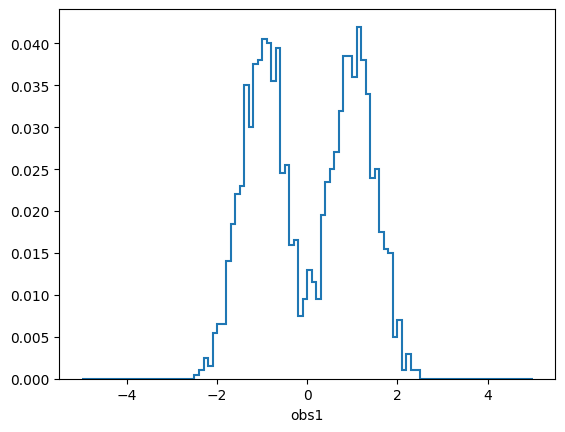

In [ ]:
mplhep.histplot(mixture.to_hist())

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x742dec509db0>, errorbar=None, legend_artist=None)]

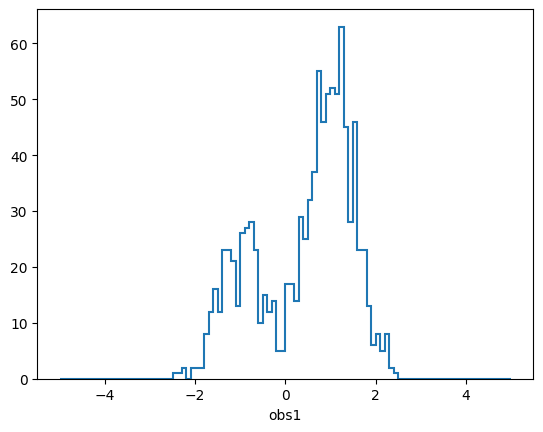

In [ ]:
mplhep.histplot(mixture.sample(n=1000, params={'frac_binned': 0.3}))

### Composed PDFs

So far, we only looked at creating a model that depends on parameters and data but did not include other models. This is crucial to create for example sums or products of PDFs. Instead of inheriting from `BasePDF`, we can use the `BaseFunctor` that contains a mixin which handles daughter PDFs correctly.

The main difference is that we can now provide a list of PDFs that our model depends on. There can still be parameters (as for example the `fracs` for the sum) that describe the behavior of the models but they can also be omitted (e.g. for the product). _Sidenote: technically, a normal `BasePDF` can of course also have no parameters, however, since this is a constant function without dependencies, this will rarely be used in practice.

In [ ]:
class SquarePDF(zfit.pdf.BaseFunctor):
    """Example of a functor pdf that takes the log of a single PDF.

    DEMONSTRATION PURPOSE ONLY, DO **NOT** USE IN REAL CASE.
    """

    def __init__(self, pdf1, name="SumOf3"):
        pdfs = [pdf1]  # we could have more of course, e.g. for sums
        # no need for parameters here, so we can omit it
        obs = pdf1.space
        super().__init__(pdfs=pdfs, obs=obs, name=name)

    @zfit.supports(norm=False)
    def _pdf(self, x, norm, params):
        del norm
        # we do not need to unstack x here as we want to feed it directly to the pdf1
        pdf1 = self.pdfs[0]

        return pdf1.pdf(x) ** 2

In [ ]:
squarepdf = SquarePDF(pdf1=poly2)

In [ ]:
squarepdf.integrate(limits=(-2, 3.2))

In [ ]:
sample_square = squarepdf.sample(n=1000)
sample_square

In [ ]:
squarepdf.pdf(sample_square)[:10]

## ...and now?

We've implemented a custom PDF. Maybe spent quite some time fine tuning it, debugging it. Adding an integral. And now? Time to make it available to others: [zfit-physics](https://github.com/zfit/zfit-physics). This repository is meant for community contributions. It has less requirements to contribute than to zfit core and has a low threshold. Core devs can provide you with help and you can provide the community with a PDF.

Make an issue or a PR, everything is welcome!

### Mixing with pure Python

Whenever possible, it is preferrable to write anything in TensorFlow. But there is the possibility to mix with pure Python, however losing many of the benefits that TensorFlow provides. To do so:

- try to use `z.py_function` or `tf.py_function` to wrap pure Python code
- if you write something and want to make sure it is run in eager mode, use `zfit.run.assert_executing_eagerly()`. This way, your function won't be compiled and an error would be raised.
- set the graph mode and numerical gradient accordingly

In [ ]:
x_tf = z.constant(42.)


def sqrt(x):
    return np.sqrt(x)


y = z.py_function(func=sqrt, inp=[x_tf], Tout=tf.float64)

This raises a warning: since we do not use pure TensorFlow anymore, it means that the automatic gradient (potentially) fails, as it cannot be traced through Python operations. Depending on the use-case, this is not a problem. That's why the warning is an `AdvancedFeatureWarning`: it doesn't say what we're doing is wrong, it simply warns that we should know what we're doing; it can also be switched off as explained in the warning.

It is technically not always required: if we e.g. use the internal, numerical gradient of a minimizer such as Minuit, the global setting does not really matter anyway.

This follows strongly the zfit philosophy that there _must_ not be any bounds in terms of flexibility and even hackability of the framework, this should be an inherent part of it. However, the user should be made aware when leaving "the safe path".

To do what the above warning told us to do, we can use `zfit.run.set_autograd_mode(False)`.

This is needed whenever we want to use non-traceable Python calls in the dynamic calculations, be it by using `py_function` or be it by switching off the gradient mode as shown below.

#### Sidestep: What is 'z'?

This is a subset of TensorFlow, wrapped to improve dtype handling and sometimes even provide additional functionality, such as `z.function` decorator.

### Full Python compatibility

To operate in a full Python compatible, yet (way) less efficient mode, we can switch off the automatic gradient, as discussed before, and the graph compilation, leaving us with a Numpy-like TensorFlow

In [ ]:
zfit.run.set_graph_mode(False)
zfit.run.set_autograd_mode(False)

We can now build a Gaussian purely based on Numpy. As we have seen when building graphs with TensorFlow: anything Python-like will be converted to a static value in the graph. So we have to make sure that our code is never run in graph mode but only executed eagerly.

This can be done by calling `zfit.run.assert_executing_eagerly()`, which raises an error if this code is run in graph mode.

Note that omitting the graph mode means to loose many optimizations: Not only do we loose the whole TensorFlow speedup from the graph, we also perform redundant tasks that are not cached, since zfit itself is optimized to be run in the graph mode.
However, practially, this mode should anyway be used rather rarely and compares still in the same order of magnitude as alternatives.

In [ ]:
class NumpyGauss(zfit.pdf.ZPDF):
    _PARAMS = ['mu', 'sigma']

    @zfit.supports()
    def _unnormalized_pdf(self, x, params):
        zfit.run.assert_executing_eagerly()  # make sure we're eager
        data = x[0]
        mu = params['mu']
        sigma = params['sigma']
        return np.exp( - 0.5 * (data - mu) ** 2 / sigma ** 2)  # note that we use numpy here

This can be tested and compared.

In [ ]:
obs = zfit.Space('obs1', (-3, 3))
mu = zfit.Parameter('mu', 0., -1, 1)
sigma = zfit.Parameter('sigma', 1., 0.1, 10)

In [ ]:
gauss_np = NumpyGauss(obs=obs, mu=mu, sigma=sigma)
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

In [ ]:
integral_np = gauss_np.integrate((-1, 0))
integral = gauss.integrate((-1, 0))
print(integral_np, integral)